# HR Analytics - Retaining High-Performers

    The source of this data was https://www.kaggle.com/ludobenistant/hr-analytics. In the Kaggle example provided, 
    the problem "concerns a big company that wants to understand why some of their best and most experienced 
    employees are leaving prematurely. The company also wishes to predict which valuable employees will leave next."
    
    This analysis will show how we can use predictive modelling to help companies save time and money on recruiting
    new talent. We can do this by using the data generated by their internal HR team to predict which high 
    performing employees might be at risk to leave the company and alert the team before it happens.

## Data Exploration

In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn import model_selection

plt.style.use('ggplot')

hr = pd.read_csv("HR_comma_sep.csv")
hr.department = hr.department.astype("category")
hr.salary = hr.salary.astype("category")
hr.salary.cat.set_categories(["low", "medium", "high"], inplace = True)

Looking at some basic info about our data, we can see that we have 14999 observations and that the employee attrition rate is just below 24.0%. In order to find at-risk high performers, we can look at the distribution of evaluations.


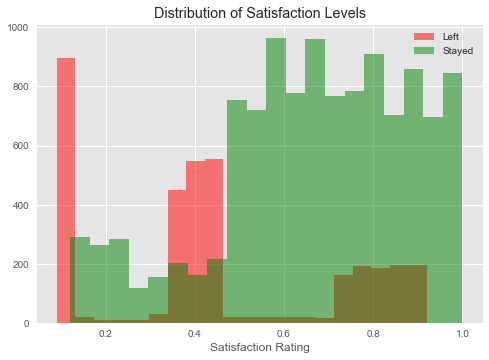

In [9]:
# Visual examination of the relationship between satisfaction level and whether the employee left
bins = 20
left = hr[hr['left']==1]['satisfaction_level']
stay = hr[hr['left']==0]['satisfaction_level']
plt.hist(left, bins = bins, alpha = 0.5, color = 'red', label = 'Left')
plt.hist(stay, bins = bins, alpha = 0.5, color = 'green', label = 'Stayed')
plt.legend()
plt.xlabel('Satisfaction Rating')
plt.title("Distribution of Satisfaction Levels")
plt.show()

Based on satisfaction levels, there seems to be 3 large segments of people who leave.
- Employees who absolutely hate the company (possibly performing poorly)
- Employees who dislike the company
- Employees who had a really great experience at the company but potentially found a better opportunity for growth elsewhere. (Potentially the group we're interested in)

Interestingly, people who rate their satisfaction from the range 0.5 ~ 0.7 are more likely to stay than the 0.75 ~ 0.9 group. One explanation could be that the individuals who vote that way are more likely to be the indecisive / 'meh' type and therefore less motivated to look for opportunities elsewhere.

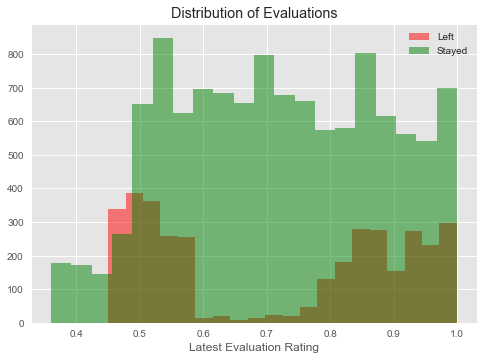

In [10]:
bins = 20
left = hr[hr['left']==1]['last_evaluation']
stay = hr[hr['left']==0]['last_evaluation']
plt.hist(left, bins = bins, alpha = 0.5, color = 'red', label = 'Left')
plt.hist(stay, bins = bins, alpha = 0.5, color = 'green', label = 'Stayed')
plt.legend()
plt.xlabel('Latest Evaluation Rating')
plt.title("Distribution of Evaluations")
plt.show()

Not surprisingly, a large percentage of people who leave are low performers that have below average evaluations. However, there are a group of individuals with high performance that are leaving as well. We'll subset our data and focus on predicting turnover among this group.

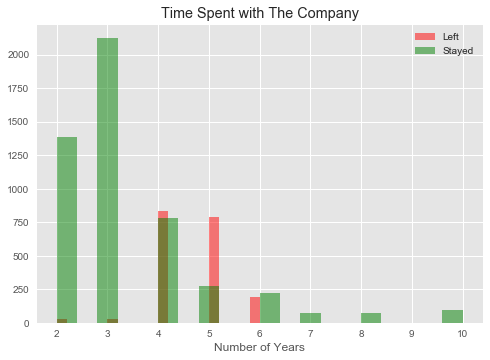

In [11]:
hr = hr.loc[hr.last_evaluation >= .75]
ind = np.arange(10)
width = 0.4
left = hr[hr['left']==1]['time_spend_company']
stay = hr[hr['left']==0]['time_spend_company']
plt.hist(left, bins = bins, alpha = 0.5, color = 'red', label = 'Left')
plt.hist(stay, bins = bins, alpha = 0.5, color = 'green', label = 'Stayed')
plt.legend()
plt.xlabel('Number of Years')
plt.title("Time Spent with The Company")
plt.show()

Since we're interested in explaining why the company's best and most experienced employees are leaving, we'll subset the data again and only include those with 4 or more years of experience.

In [12]:
hr = hr.loc[hr.time_spend_company >= 4]
hr.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,3345.000000,3345.000000,3345.000000,3345.000000,3345.000000,3345.000000,3345.000000,3345.000000
mean,0.523274,0.885411,4.734828,232.811061,4.893871,0.099851,0.543797,0.016741
std,0.324526,0.070570,1.253678,48.156216,1.264311,0.299845,0.498153,0.128320
min,0.090000,0.750000,2.000000,96.000000,4.000000,0.000000,0.000000,0.000000
25%,0.110000,0.830000,4.000000,203.000000,4.000000,0.000000,0.000000,0.000000
50%,0.620000,0.890000,5.000000,245.000000,5.000000,0.000000,1.000000,0.000000
75%,0.820000,0.940000,6.000000,267.000000,5.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


When we look at a subset of the data with only the best and most experienced, the turnover problem becomes even more pronounced, with almost 55% of the company's most valuable employees leaving the company prematurely. For the high performers, let's take a look at which features are correlated with the employee leaving..


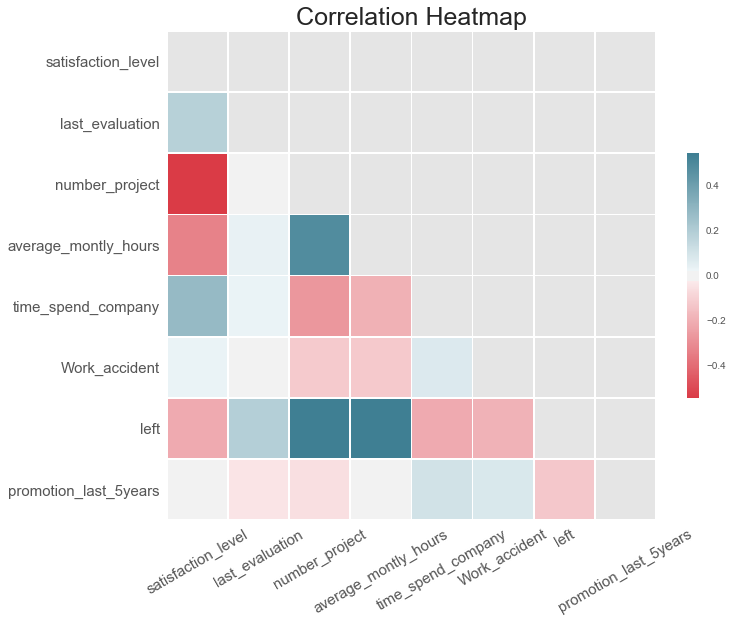

In [13]:
corr = hr.corr()
# Hide top right half of the diagonal
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Set custom color map
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, vmax=.3, cmap = cmap, linewidths=.75,
            square=True, cbar_kws={"shrink": .5}, ax=ax)
sns.plt.xticks(rotation = 30, size = 15)
sns.plt.yticks(size = 15)
sns.plt.title('Correlation Heatmap', size = 25)
sns.plt.show()

Looking at the row of correlations for left, not very surprisingly, the high-performing employees who leave are the ones who on average report a lower satisfaction level, work more hours per month and on many different projects, but are not getting promoted.

One interesting observation to note is that you someone did in their last performance evaluation doesn't really positively correlate with whether the person was promoted in the last five years - In fact, it's actually slightly negatively correlated. This potentially suggests that the company might want need to adjust their promotion practices to align with performance.


Let's build a model to predict turnover among our group of interest! I'll choose a logistic regression model for its simplicity . We also have fairly small number of features and samples, so using a low-variance model would be less prone to overfitting.

In [14]:
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

hr2 = pd.get_dummies(hr, prefix=['department', 'salary'])
hr_target = hr2['left']
hr_data = hr2.drop(['left'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(hr_data, hr_target, test_size=0.4, random_state=0)
logistic = lm.LogisticRegression()
reg = logistic.fit(X_train / np.std(X_train, 0), y_train)
# Add predictions to our test dataset
X_test.loc[:,'prediction'] = reg.predict_proba(X_test / np.std(X_test, 0))[:,1]
# Looking at the coefficients for the logistic regression. Decision trees was probably a better option if we're
#  going for interpretability
display(zip(list(X_train.columns), reg.coef_[0]))

# Sort by most likely to leave
X_test = X_test.sort_values(by='prediction', ascending = False, axis = 0, inplace=False)

[('satisfaction_level', 0.34538372342831658),
 ('last_evaluation', 0.37639305733568834),
 ('number_project', 1.2249249613863207),
 ('average_montly_hours', 1.2788215846251714),
 ('time_spend_company', -0.21038392417152021),
 ('Work_accident', -0.26188839417929305),
 ('promotion_last_5years', -0.2602929231920042),
 ('department_IT', -1.2073743618448736),
 ('department_RandD', -0.96729987769975856),
 ('department_accounting', -1.1156901411081492),
 ('department_hr', -0.93913647945934542),
 ('department_management', -0.92497361312268933),
 ('department_marketing', -0.96617333588962606),
 ('department_product_mng', -1.2327568876292729),
 ('department_sales', -2.0120122330425034),
 ('department_support', -1.558953046336409),
 ('department_technical', -1.6825404030283975),
 ('salary_low', -3.2759135798183339),
 ('salary_medium', -3.4560114604082171),
 ('salary_high', -2.0060849292990142)]

In [15]:
display(X_test.head())

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department_IT,department_RandD,department_accounting,...,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium,salary_high,prediction
1840,0.10,0.97,7,306,4,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.991426
12160,0.10,0.95,7,301,4,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.989151
14810,0.11,0.92,7,307,4,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.988877
599,0.11,0.92,7,307,4,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.988877
936,0.10,0.95,7,301,4,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0.987528


Summary: We can use this model to predict our best employees who are at risk of turnover. One possibility is to 
    integrate it with the performance evaluation platform/process. After the performance evaluation is complete, we're
    able to provide the manager with a risk profile of the employee he/she reviewed, and suggest potential
    recommendations. (Fewer projects, less hours, promotion, etc.)